In [44]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score



In [45]:
# Define environment-specific paths
WORKING_ENV = 'local'  # Change as needed

if WORKING_ENV == 'cluster':
    content_path = '/vol/bitbucket/pvr24/nlp_cw_et1224_pvr24/'
    data_path = f'{content_path}data'
    cache_dir = f'{content_path}huggingface_cache'  # Define a cache directory on Bitbucket

elif WORKING_ENV == 'local':
    content_path = './'
    data_path = './data/'
    cache_dir = './huggingface_cache'
    os.makedirs(data_path, exist_ok=True)

else:
    raise NotImplementedError()

# Ensure cache directory exists
os.makedirs(cache_dir, exist_ok=True)

# Set Hugging Face cache directory
os.environ["HF_HOME"] = cache_dir

In [46]:
predicitions = df = pd.read_csv("dev.txt", header=None, names=["label_pred"], dtype=int)

In [47]:
official_dev = pd.read_csv(f'{data_path}/test.csv')
complete_data = pd.read_csv(f'{data_path}/dontpatronizeme_pcl.tsv', sep='\t', header=None, skiprows=4, names=['par_id','art_id','keyword','country_code','text','patronizing_lvl'])
complete_data = complete_data.drop(columns=['art_id','keyword','country_code', 'text'])
official_dev = official_dev.merge(complete_data, on='par_id', how='left')
assert(len(official_dev) == len(predicitions))

df = pd.concat([official_dev, predicitions], axis=1)
df = df.drop(columns=['par_id', 'art_id'])
df = df.drop(df.columns[0], axis=1)
df['text'] = df['text'].astype(str)
df['length'] = df['text'].apply(lambda x: len(x))
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

#create 10 bins for character length and word count
df['length_lvl'] = pd.qcut(df['length'], q=4, labels=False)
df['word_lvl'] = pd.qcut(df['word_count'], q=4, labels=False)

df

,keyword,country_code,text,label,category_label,patronizing_lvl,label_pred,length,word_count,length_lvl,word_lvl
0,hopeless,us,We also know that they can benefit by receivin...,1,"[1, 0, 0, 1, 0, 0, 0]",3,0,493,85,3,3
1,refugee,ng,Pope Francis washed and kissed the feet of Mus...,1,"[0, 1, 0, 0, 0, 0, 0]",4,1,197,38,1,1
2,refugee,ng,Many refugees do n't want to be resettled anyw...,1,"[0, 0, 1, 0, 0, 0, 0]",2,0,74,16,0,0
3,in-need,ie,"Budding chefs , like "" Fred "" , "" Winston "" an...",1,"[1, 0, 0, 1, 1, 1, 0]",4,1,210,42,1,2
4,homeless,pk,"In a 90-degree view of his constituency , one ...",1,"[1, 0, 0, 0, 0, 0, 0]",3,0,351,70,3,3
...,...,...,...,...,...,...,...,...,...,...,...
2089,homeless,gh,"The sad spectacle , which occurred on Saturday...",0,"[0, 0, 0, 0, 0, 0, 0]",0,0,230,43,2,2
2090,refugee,pk,""" The Pakistani police came to our house and t...",0,"[0, 0, 0, 0, 0, 0, 0]",0,0,166,37,1,1
2091,disabled,ie,When Marie O'Donoghue went looking for a speci...,0,"[0, 0, 0, 0, 0, 0, 0]",0,0,199,38,1,1
2092,women,lk,Sri Lankan norms and culture inhibit women fro...,0,"[0, 0, 0, 0, 0, 0, 0]",1,0,344,64,3,3


In [48]:
#calculate f1 score overall on label and label_pred on positive class
print(f1_score(df['label'], df['label_pred'], average='binary'))
#calculate accuracy
print((df['label'] == df['label_pred']).mean())

0.5569007263922519
0.9126074498567335


In [49]:
def compute_f1(group):
    return f1_score(group['label'], group['label_pred'], pos_label=1)

patronizing_accuracy = df.groupby('patronizing_lvl').apply(lambda x: (x['label'] == x['label_pred']).mean())
patronizing_f1 = df.groupby('patronizing_lvl').apply(compute_f1)

length_accuracy = df.groupby('length_lvl').apply(lambda x: (x['label'] == x['label_pred']).mean())
length_f1 = df.groupby('length_lvl').apply(compute_f1)

word_accuracy = df.groupby('word_lvl').apply(lambda x: (x['label'] == x['label_pred']).mean())
word_f1 = df.groupby('word_lvl').apply(compute_f1)

keyword_accuracy = df.groupby('keyword').apply(lambda x: (x['label'] == x['label_pred']).mean())
keyword_f1 = df.groupby('keyword').apply(compute_f1)

country_accuracy = df.groupby('country_code').apply(lambda x: (x['label'] == x['label_pred']).mean())
country_f1 = df.groupby('country_code').apply(compute_f1)

C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\1096411108.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patronizing_accuracy = df.groupby('patronizing_lvl').apply(lambda x: (x['label'] == x['label_pred']).mean())
C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\1096411108.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patronizing_f1 = df.groupby('patronizing_lvl').apply(compute_f1)
C:\Users\p

In [50]:
# Get min & max for each bin in length_lvl
length_ranges = df.groupby("length_lvl")["length"].agg(["min", "max"])
length_ranges = length_ranges.apply(lambda x: f"{x['min']} - {x['max']}", axis=1)

# Get min & max for each bin in word_lvl
word_ranges = df.groupby("word_lvl")["word_count"].agg(["min", "max"])
word_ranges = word_ranges.apply(lambda x: f"{x['min']} - {x['max']}", axis=1)

# Map these actual numeric ranges to replace categorical labels
length_accuracy.index = length_ranges.values
length_f1.index = length_ranges.values
word_accuracy.index = word_ranges.values
word_f1.index = word_ranges.values

df["length_lvl"] = df["length_lvl"].map(length_ranges)
df["word_lvl"] = df["word_lvl"].map(word_ranges)

In [51]:
print(metrics)

[(patronizing_lvl
0    0.965376
1    0.790576
2    0.277778
3    0.483146
4    0.728261
dtype: float64, 'Patronizing Level - Accuracy', <Axes: title={'center': 'Patronizing Level - Accuracy'}, ylabel='Score'>), (patronizing_lvl
0    0.000000
1    0.000000
2    0.434783
3    0.651515
4    0.842767
dtype: float64, 'Patronizing Level - F1 Score', <Axes: title={'center': 'Patronizing Level - F1 Score'}, ylabel='Score'>), (3 - 165       0.933712
166 - 228     0.924855
229 - 319     0.929524
320 - 1446    0.862069
dtype: float64, 'Text Length (Min-Max Range) - Accuracy', <Axes: title={'center': 'Text Length (Min-Max Range) - Accuracy'}, ylabel='Score'>), (3 - 165       0.578313
166 - 228     0.613861
229 - 319     0.574713
320 - 1446    0.492958
dtype: float64, 'Text Length (Min-Max Range) - F1 Score', <Axes: title={'center': 'Text Length (Min-Max Range) - F1 Score'}, ylabel='Score'>), (1 - 30      0.939394
31 - 41     0.920408
42 - 58     0.928983
59 - 272    0.860153
dtype: float64, 'Word 

C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\812499372.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric.index, y=metric.values, ax=ax, palette="viridis")
C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\812499372.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\812499372.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric.index, y=metric.values, ax=ax, palette="viridis")
C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\812499372.py:25: UserWarning: set_ticklabels() should

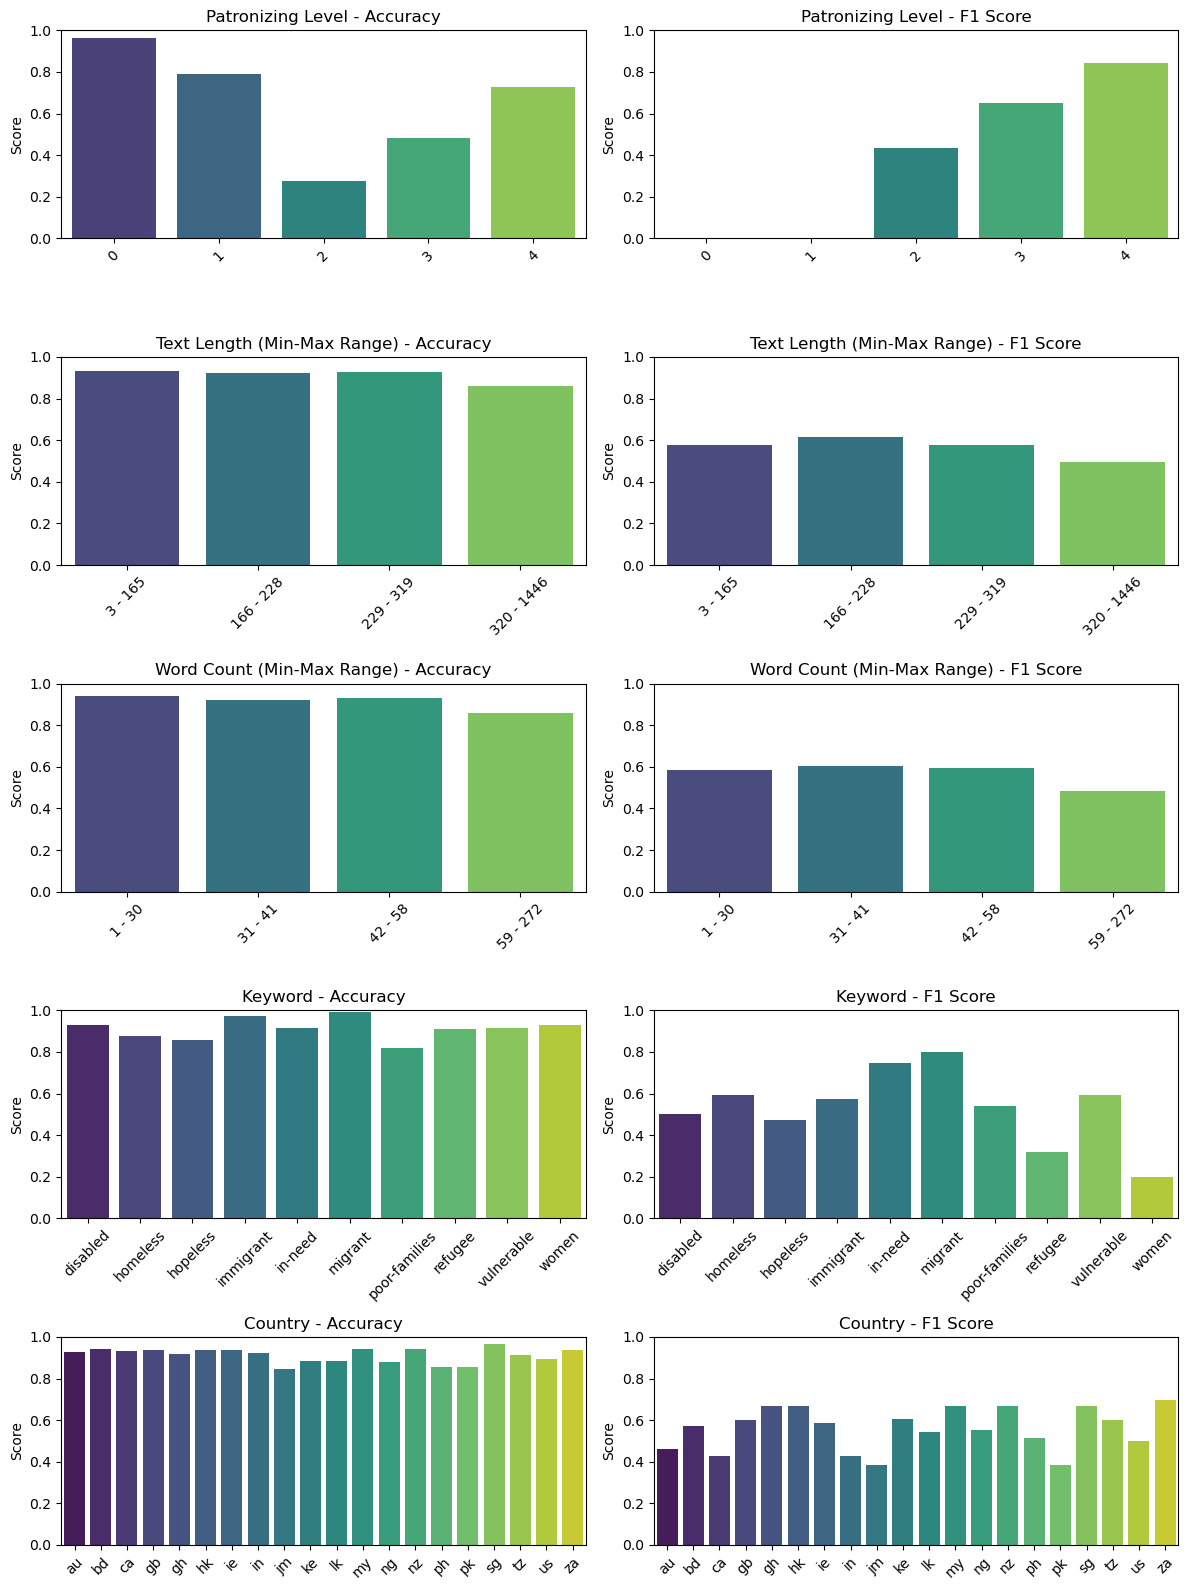

In [52]:
# Create figure with subplots (5 rows, 2 cols)
fig, axes = plt.subplots(5, 2, figsize=(12, 16))  

# List of accuracy & F1 scores with updated index labels
metrics = [
    (patronizing_accuracy, "Patronizing Level - Accuracy", axes[0, 0]),
    (patronizing_f1, "Patronizing Level - F1 Score", axes[0, 1]),
    (length_accuracy, "Text Length (Min-Max Range) - Accuracy", axes[1, 0]),
    (length_f1, "Text Length (Min-Max Range) - F1 Score", axes[1, 1]),
    (word_accuracy, "Word Count (Min-Max Range) - Accuracy", axes[2, 0]),
    (word_f1, "Word Count (Min-Max Range) - F1 Score", axes[2, 1]),
    (keyword_accuracy, "Keyword - Accuracy", axes[3, 0]),
    (keyword_f1, "Keyword - F1 Score", axes[3, 1]),
    (country_accuracy, "Country - Accuracy", axes[4, 0]),
    (country_f1, "Country - F1 Score", axes[4, 1])
]

# Plot each metric
for metric, title, ax in metrics:
    sns.barplot(x=metric.index, y=metric.values, ax=ax, palette="viridis")
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)  # Keep y-axis consistent for comparison
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\4142368919.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=ax, order=df[col].value_counts().index, palette="mako")
C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\4142368919.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\4142368919.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=ax, order=df[col].value_counts().index, palette="mako")
C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\4142368919.py:24: UserWa

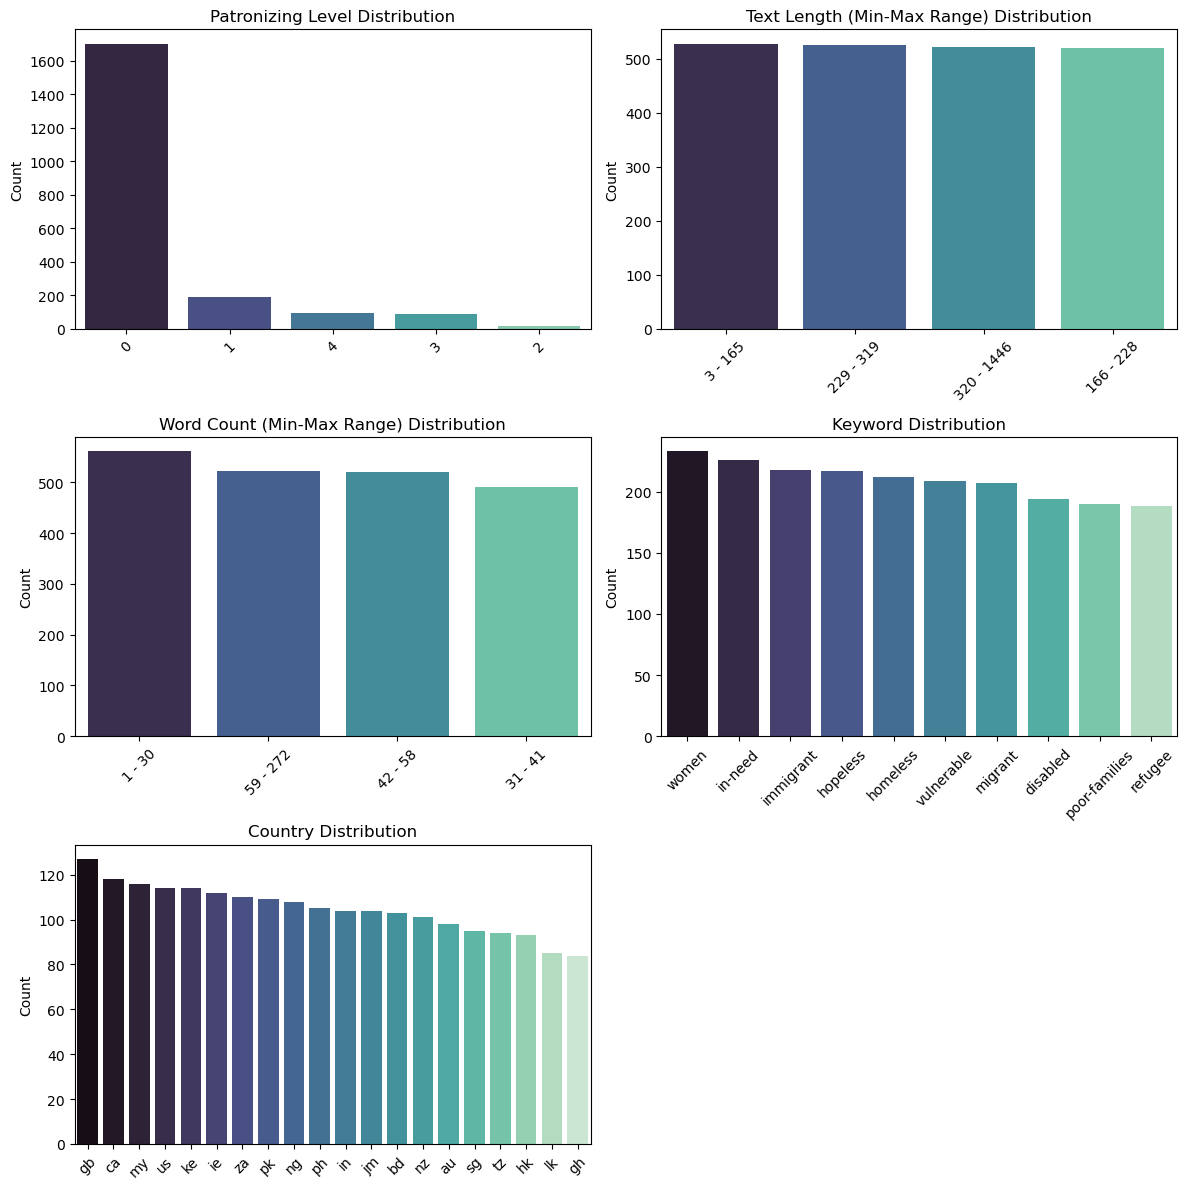

In [53]:
# Create figure with subplots (3 rows, 2 cols)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  

# Count distributions with updated labels
count_metrics = [
    ("patronizing_lvl", "Patronizing Level Distribution", axes[0, 0]),
    ("length_lvl", "Text Length (Min-Max Range) Distribution", axes[0, 1]),
    ("word_lvl", "Word Count (Min-Max Range) Distribution", axes[1, 0]),
    ("keyword", "Keyword Distribution", axes[1, 1]),
    ("country_code", "Country Distribution", axes[2, 0])
]

# Plot counts
for col, title, ax in count_metrics:
    # Plot the countplot with mapped ranges for length_lvl and word_lvl
    if col in ['length_lvl', 'word_lvl']:  # Special handling for these columns
        sns.countplot(x=df[col], ax=ax, order=df[col].value_counts().index, palette="mako")
    else:
        sns.countplot(x=df[col], ax=ax, order=df[col].value_counts().index, palette="mako")
    
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Hide last empty subplot
axes[2, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\1789898542.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentage = df.groupby(col).apply(lambda x: (x['label'] == 1).mean()*100)
C:\Users\paulr\AppData\Local\Temp\ipykernel_20896\1789898542.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentage = df.groupby(col).apply(lambda x: (x['label'] == 1).mean()*100)
C:\Users\paulr\AppData\Local\Temp\

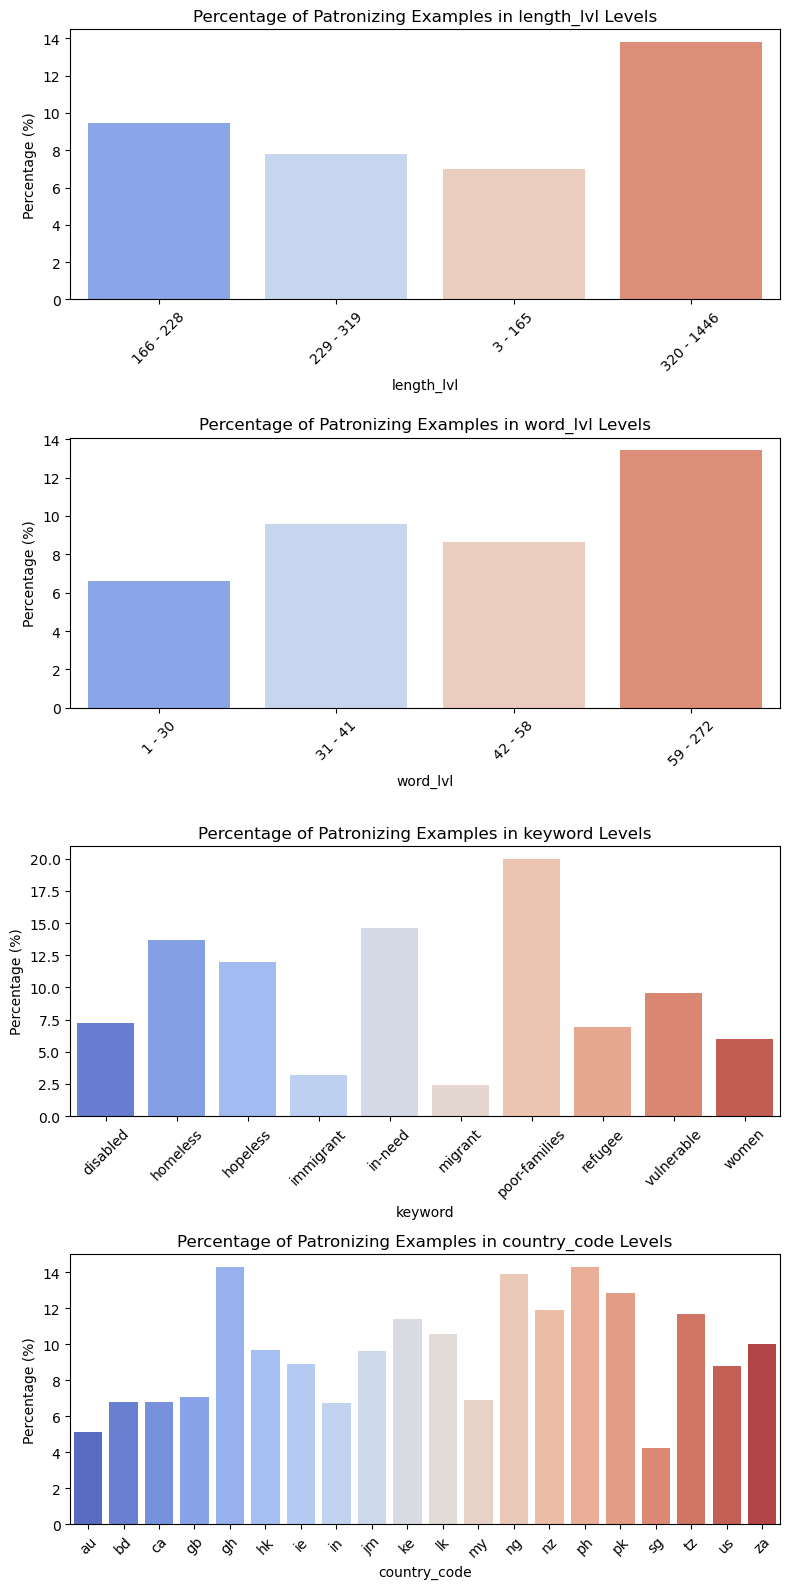

In [54]:
# Calculate the percentage of patronizing examples in each bin for different categories
patronizing_percentage = {}

# For each of the bins (patronizing_lvl, length_lvl, word_lvl, keyword, country_code)
for col in ['length_lvl', 'word_lvl', 'keyword', 'country_code']:
    # Calculate the percentage of patronizing examples within each bin
    percentage = df.groupby(col).apply(lambda x: (x['label'] == 1).mean()*100)
    patronizing_percentage[col] = percentage

# Create a 5-row, 1-column figure for each partition's patronizing percentage plot
fig, axes = plt.subplots(4, 1, figsize=(8, 16))

# Plot for each partition
for i, col in enumerate(patronizing_percentage):
    ax = axes[i]
    sns.barplot(x=patronizing_percentage[col].index, y=patronizing_percentage[col].values, ax=ax, palette="coolwarm")
    ax.set_title(f"Percentage of Patronizing Examples in {col} Levels")
    ax.set_xlabel(col)
    ax.set_ylabel("Percentage (%)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()